In [0]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_probabilistic_robotics/'
sys.path.append(CURR_DIR)
sys.path.append(CURR_DIR + 'scripts/')

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [0]:
from puddle_world import *
import itertools
import collections

In [0]:
%matplotlib inline
print(matplotlib.get_backend())

module://ipykernel.pylab.backend_inline


In [0]:
class DynamicProgramming:
    def __init__(
        self, widths, goal, puddles, time_interval, sampling_num,
        puddle_coef=100, lower_left=np.array([-4,-4]), upper_right=np.array([4,4])
    ):
        self.pose_min = np.array([*lower_left, math.radians(0)]) # [m], [m], [rad]
        self.pose_max = np.array([*upper_right, math.radians(360)]) # [m], [m], [rad]
        self.widths = widths
        self.goal = goal

        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        n_x, n_y, n_theta = self.index_nums
        self.indexes = list(itertools.product(range(n_x), range(n_y), range(n_theta)))

        self.value_function, self.final_state_flags = self.init_value_function()
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[index]) for index in self.indexes]))

        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.puddle_depths = self.puddle_depth_means(puddles, sampling_num)

        self.time_interval = time_interval
        self.puddle_coef = puddle_coef

    def init_value_function(self):
        value_function = np.empty(self.index_nums)
        final_state_flags = np.zeros(self.index_nums)
        for index in self.indexes:
            final_state_flags[index] = self.final_state(np.array(index))
            value_function[index] = self.goal.value if final_state_flags[index] else -100
        return value_function, final_state_flags

    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1)
        corners = [
            [x_min, y_min],
            [x_min, y_max],
            [x_max, y_min],
            [x_max, y_max]
        ]
        return all([self.goal.is_inside(np.array(coner)) for coner in corners])

    def init_policy(self):
        policy = np.zeros([*self.index_nums, 2])
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index) + 0.5) # [m], [m], [rad] 
            policy[index] = PuddleIgnoreAgent.policy(center, self.goal)
        return policy

    def init_state_transition_probs(self, time_interval, sampling_num):
        margin = 0.001
        dx = np.linspace(margin*self.widths[0], (1-margin)*self.widths[0], sampling_num)
        dy = np.linspace(margin*self.widths[1], (1-margin)*self.widths[1], sampling_num)
        dtheta = np.linspace(margin*self.widths[2], (1-margin)*self.widths[2], sampling_num)
        samples = list(itertools.product(dx, dy, dtheta))
        
        state_transition_probs = {}
        for action in self.actions:
            for i_theta in range(self.index_nums[2]):
                delta_indexes = []
                for x in samples:
                    before_pose = np.array([x[0], x[1], x[2]+i_theta*self.widths[2]]) + self.pose_min
                    before_index = np.array([0, 0, i_theta])

                    nu, omega = action
                    after_pose = IdealRobot.state_transition(before_pose, nu, omega, time_interval)
                    after_index = np.floor((after_pose - self.pose_min)/self.widths).astype(int)

                    delta_indexes.append(after_index - before_index)

                unique_delta_indexes, counts = np.unique(delta_indexes, axis=0, return_counts=True)
                probs = [count/len(samples) for count in counts]
                state_transition_probs[(action, i_theta)] = list(zip(unique_delta_indexes, probs))

        return state_transition_probs

    def puddle_depth_means(self, puddles, sampling_num):
        dx = np.linspace(0.0, self.widths[0], sampling_num)
        dy = np.linspace(0.0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))

        puddle_depths = np.zeros(self.index_nums[0:2])
        for i_xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            i_x, i_y = i_xy
            for x in samples:
                pose = np.array([x[0], x[1], 0]) + np.array([i_x, i_y, 0])*self.widths + self.pose_min
                for puddle in puddles:
                    puddle_depths[i_xy] += puddle.is_inside(pose)*puddle.depth

            puddle_depths[i_xy] /= len(samples)

        return puddle_depths 

    def value_iteration_sweep(self):
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                qs = [self.action_value(action, index) for action in self.actions]
                max_q = max(qs)
                max_a = self.actions[np.argmax(qs)]
                delta = abs(max_q - self.value_function[index])
                max_delta = max(delta, max_delta)
                self.value_function[index] = max_q 
                self.policy[index] = np.array(max_a)
        return max_delta

    def policy_evaluation_sweep(self):
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                delta = abs(q - self.value_function[index])
                max_delta = max(delta, max_delta)
                self.value_function[index] = q 
        return max_delta

    def action_value(self, action, index, out_penalty=True):
        value = 0.0
        i_theta = index[2]
        for delta_index, prob in self.state_transition_probs[(action, i_theta)]:
            after_index, out_reward = self.out_correction(np.array(index) + delta_index)
            after_index = tuple(after_index)
            reward = -self.time_interval - self.puddle_coef*self.puddle_depths[(after_index[0], after_index[1])]*self.time_interval + out_penalty*out_reward
            value += prob*(reward + self.value_function[after_index])
        return value

    def out_correction(self, index):
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2]

        out_reward = 0.0
        for i in range(2):
            if index[i] < 0:
                index[i] = 0
                out_reward = -1.0e+100
            elif self.index_nums[i] <= index[i]:
                index[i] = self.index_nums[i] - 1
                out_reward = -1.0e+100

        return index, out_reward

In [0]:
widths = np.array([0.2, 0.2, math.radians(10)]) # [m], [m], [rad]
goal = Goal(-3, -3)
puddles = [Puddle(lower_left=(-2,0), upper_right=(0,2), depth=0.1), Puddle(lower_left=(-0.5,-2), upper_right=(2.5,1), depth=0.1)]
time_interval = 0.1
sampling_num = 10

dp = DynamicProgramming(widths, goal, puddles, time_interval, sampling_num)

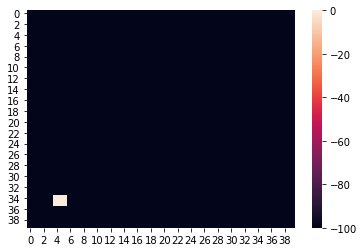

In [0]:
v = dp.value_function[:, :, 0]
sns.heatmap(np.rot90(v), square=False)
plt.show()

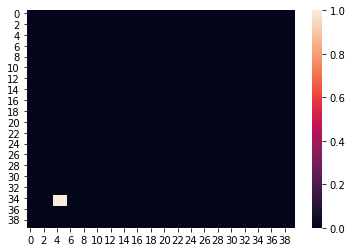

In [0]:
f = dp.final_state_flags[:, :, 0]
sns.heatmap(np.rot90(f), square=False)
plt.show()

2.0: Turn left, 1.0: Go straight, -2.0: Turn right


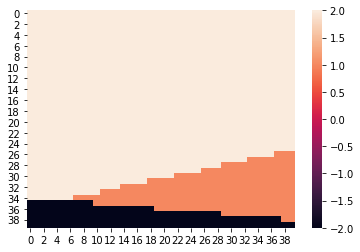

In [0]:
p = np.zeros(dp.index_nums)
for index in dp.indexes:
    p[index] = sum(dp.policy[index])

print('2.0: Turn left, 1.0: Go straight, -2.0: Turn right')
sns.heatmap(np.rot90(p[:, :, 18]), square=False)
plt.show()

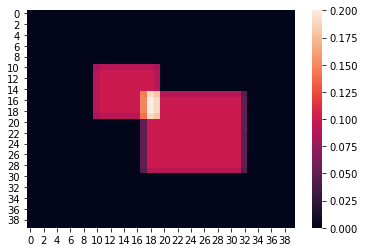

In [0]:
sns.heatmap(np.rot90(dp.puddle_depths), square=False)
plt.show()

counter = 1 , delta = 54.12620000000001
counter = 2 , delta = 52.74757270655758
counter = 3 , delta = 27.125969262448393
counter = 4 , delta = 24.34606992106817
counter = 5 , delta = 19.958651189319355
counter = 6 , delta = 18.76049257661412
counter = 7 , delta = 16.269740152865246
counter = 8 , delta = 15.811209002823418
counter = 9 , delta = 14.142432609745732
counter = 10 , delta = 13.2728154828973
counter = 11 , delta = 12.498960435974425
counter = 12 , delta = 11.734758467494146
counter = 13 , delta = 11.240074461583092
counter = 14 , delta = 10.005320081828437
counter = 15 , delta = 9.16491054491783
counter = 16 , delta = 8.716466304430085
counter = 17 , delta = 8.310483642021154
counter = 18 , delta = 7.947403110075854
counter = 19 , delta = 7.632679869857071
counter = 20 , delta = 7.390136117765529
counter = 21 , delta = 7.14031724209817
counter = 22 , delta = 6.97419489254203
counter = 23 , delta = 6.917827476767286
counter = 24 , delta = 6.70972690454002
counter = 25 , delta 

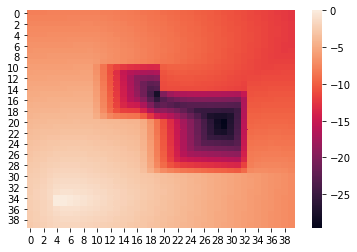

In [0]:
delta = 1.0e+100
counter = 0

while 0.01 < delta:
    delta = dp.value_iteration_sweep()
    counter += 1
    print('counter =', counter, ', delta =', delta)

v = dp.value_function[:, :, 18]
sns.heatmap(np.rot90(v), square=False)
plt.show()

In [0]:
with open('mdp_value.txt', 'w') as f:
    for index in dp.indexes:
        value = dp.value_function[index]
        ### i_x, i_y, i_theta, value
        f.write('{} {} {} {}\n'.format(index[0], index[1], index[2], value))

2.0: Turn left, 1.0: Go straight, -2.0: Turn right


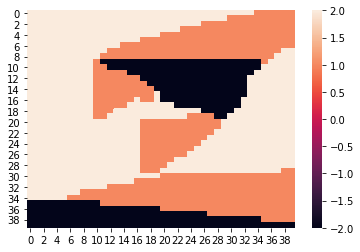

In [0]:
p = np.zeros(dp.index_nums)
for index in dp.indexes:
    p[index] = sum(dp.policy[index])

print('2.0: Turn left, 1.0: Go straight, -2.0: Turn right')
sns.heatmap(np.rot90(p[:, :, 18]), square=False)
plt.show()

In [0]:
with open('mdp_policy.txt', 'w') as f:
    for index in dp.indexes:
        action = dp.policy[index]
        ### i_x, i_y, i_theta, nu, omega
        f.write('{} {} {} {} {}\n'.format(index[0], index[1], index[2], action[0], action[1]))